In [1]:
# !pip install fastaudio
# !pip install fastai==2.5.2
# !pip install matplotlib==3.2.2
# !pip install scikit-learn==1.0.2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score

import numpy as np
import pandas as pd

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Preprocessing

In [3]:
CVD_loc = "../input/coughvid-wav/"
path = '../input/coughvid-wav/public_dataset/'

In [4]:
cvd_df = pd.read_csv(CVD_loc+"public_dataset/"+"metadata_compiled.csv")
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

In [5]:
# remove unnecessary columns

cvd_df = cvd_df.drop(columns=['datetime', 'latitude', 'longitude', 'age', 'gender', 'fever_muscle_pain',
                          'cough_type_1','dyspnea_1','wheezing_1','stridor_1','choking_1','congestion_1','nothing_1',
                          'cough_type_2','dyspnea_2','wheezing_2','stridor_2','choking_2','congestion_2','nothing_2',
                          'cough_type_3','dyspnea_3','wheezing_3','stridor_3','choking_3','congestion_3','nothing_3',
                          'cough_type_4','dyspnea_4','wheezing_4','stridor_4','choking_4','congestion_4','nothing_4'
                         ])

In [6]:
# 'cough_detected' == Probability that the recording contains cough sounds, according to their automatic detection algorithm
# also expert annotation has 'quality' of the recorded cough sound

cvd_df = cvd_df[(cvd_df['cough_detected'] > 0.8) 
                & (cvd_df['quality_1'] != 'no_cough')
                & (cvd_df['quality_2'] != 'no_cough')
                & (cvd_df['quality_3'] != 'no_cough')
                & (cvd_df['quality_4'] != 'no_cough') 
                & (cvd_df['quality_1'] != 'poor')
                & (cvd_df['quality_2'] != 'poor')
                & (cvd_df['quality_3'] != 'poor')
                & (cvd_df['quality_4'] != 'poor')
               ]

cvd_df.info()
cvd_df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14844 entries, 1 to 27549
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   14844 non-null  object 
 1   cough_detected         14844 non-null  float64
 2   SNR                    14844 non-null  float64
 3   respiratory_condition  10579 non-null  object 
 4   status                 10579 non-null  object 
 5   quality_1              638 non-null    object 
 6   diagnosis_1            638 non-null    object 
 7   severity_1             638 non-null    object 
 8   quality_2              686 non-null    object 
 9   diagnosis_2            686 non-null    object 
 10  severity_2             686 non-null    object 
 11  quality_3              747 non-null    object 
 12  diagnosis_3            747 non-null    object 
 13  severity_3             747 non-null    object 
 14  quality_4              743 non-null    object 
 15  di

uuid  cough_detected        SNR  \
1   00039425-7f3a-42aa-ac13-834aaa2b6b92          0.9609  16.151433   
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a          0.9301  20.146058   
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f          0.9968  13.146502   
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952          0.8937  13.477551   
11  00291cce-36a0-4a29-9e2d-c1d96ca17242          0.9883  14.603851   

   respiratory_condition   status quality_1 diagnosis_1 severity_1 quality_2  \
1                  False  healthy       NaN         NaN        NaN       NaN   
3                   True  healthy       NaN         NaN        NaN       NaN   
5                  False  healthy       NaN         NaN        NaN       NaN   
10                 False  healthy       NaN         NaN        NaN       NaN   
11                 False  healthy       NaN         NaN        NaN       NaN   

   diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3 quality_4  \
1          NaN        NaN       NaN         NaN        NaN       NaN   
3          NaN        NaN       NaN         NaN        NaN       NaN   
5          NaN        NaN       NaN         NaN        NaN       NaN   
10         NaN        NaN       NaN         NaN        NaN       NaN   
11         NaN        NaN       NaN         NaN        NaN       NaN   

   diagnosis_4 severity_4  
1          NaN        NaN  
3          NaN        NaN  
5          NaN        NaN  
10         NaN        NaN  
11         NaN        NaN

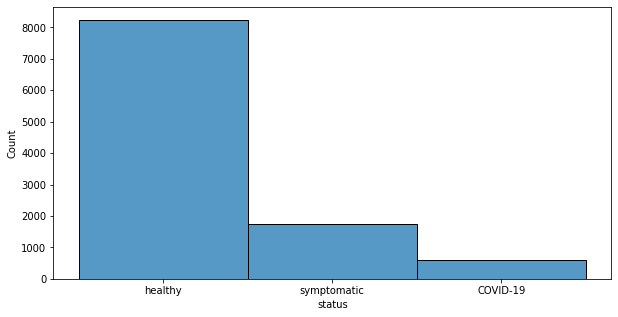

In [7]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(cvd_df['status'])

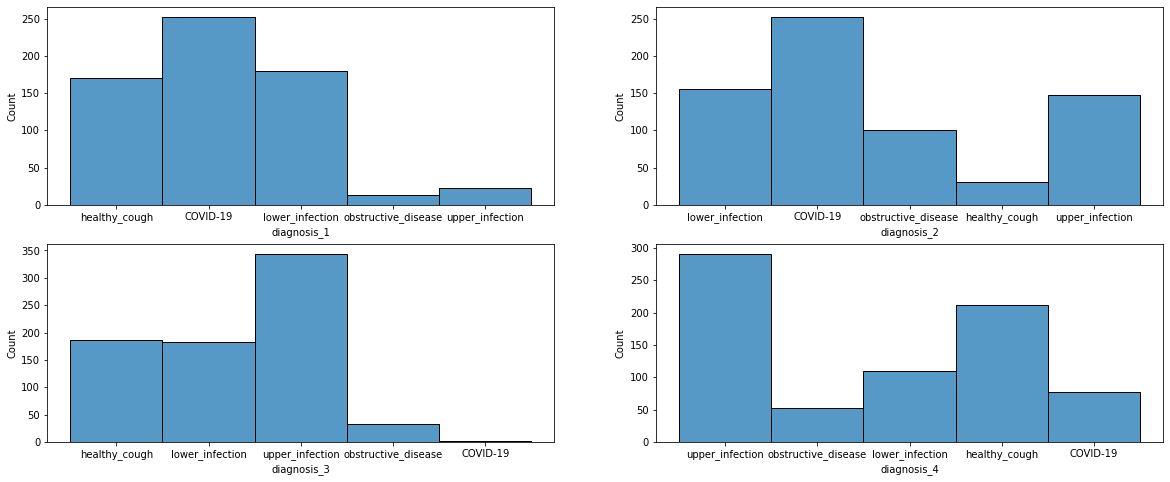

In [8]:
plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
sns.histplot(cvd_df['diagnosis_1'])
plt.subplot(2, 2, 2)
sns.histplot(cvd_df['diagnosis_2'])
plt.subplot(2, 2, 3)
sns.histplot(cvd_df['diagnosis_3'])
plt.subplot(2, 2, 4)
sns.histplot(cvd_df['diagnosis_4'])

In [9]:
# The patient's "status" is 'COVID-19' 

cvd_covid = cvd_df[(cvd_df.status == 'COVID-19')]

#cvd_covid.to_csv('cvd_covid.csv')

print('SAMPLES: -->',len(cvd_covid))
cvd_covid.info()
cvd_covid[:3]

SAMPLES: --> 596
<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 140 to 27503
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   596 non-null    object 
 1   cough_detected         596 non-null    float64
 2   SNR                    596 non-null    float64
 3   respiratory_condition  596 non-null    object 
 4   status                 596 non-null    object 
 5   quality_1              145 non-null    object 
 6   diagnosis_1            145 non-null    object 
 7   severity_1             145 non-null    object 
 8   quality_2              154 non-null    object 
 9   diagnosis_2            154 non-null    object 
 10  severity_2             154 non-null    object 
 11  quality_3              176 non-null    object 
 12  diagnosis_3            176 non-null    object 
 13  severity_3             176 non-null    object 
 14  quality_4              187 non-null  

uuid  cough_detected        SNR  \
140  015576c8-2b03-4dcb-b251-78a984fe86fe             1.0  12.265701   
155  0177b817-0ba3-498a-bc05-48bc66cc91b8             1.0  20.441756   
158  01820f7c-b953-4faf-aa13-978cfda6b08e             1.0   9.280698   

    respiratory_condition    status quality_1 diagnosis_1 severity_1  \
140                 False  COVID-19       NaN         NaN        NaN   
155                 False  COVID-19       NaN         NaN        NaN   
158                 False  COVID-19       NaN         NaN        NaN   

    quality_2          diagnosis_2 severity_2 quality_3 diagnosis_3  \
140       NaN                  NaN        NaN       NaN         NaN   
155        ok  obstructive_disease       mild       NaN         NaN   
158       NaN                  NaN        NaN       NaN         NaN   

    severity_3 quality_4          diagnosis_4 severity_4  
140        NaN      good  obstructive_disease       mild  
155        NaN       NaN                  NaN        NaN  
158        NaN      good  obstructive_disease     severe

In [10]:
# The patient "status" is 'healthy'
# to balance the ratio with covid positive samples, added some extra condition like ->
# patinet has 'no' "respiratory_condition" AND
# expert "diagnosis" is not 'upper_infection, lower_infection, obstructive_disease, COVID-19 and
# selected 1788 (3x times covid positive samples) after sorting the dataframe by 'cough_detected', 'SNR' values
 
cvd_healthy = cvd_df[(cvd_df['status'] == 'healthy') 
                     &(cvd_df['respiratory_condition'] == False) 
                     &(cvd_df['diagnosis_1'] != 'upper_infection')
                     &(cvd_df['diagnosis_2'] != 'upper_infection')
                     &(cvd_df['diagnosis_3'] != 'upper_infection')
                     &(cvd_df['diagnosis_4'] != 'upper_infection') 
                     &(cvd_df['diagnosis_1'] != 'lower_infection')
                     &(cvd_df['diagnosis_2'] != 'lower_infection')
                     &(cvd_df['diagnosis_3'] != 'lower_infection')
                     &(cvd_df['diagnosis_4'] != 'lower_infection')
                     &(cvd_df['diagnosis_1'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_2'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_3'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_4'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_1'] != 'COVID-19')
                     &(cvd_df['diagnosis_2'] != 'COVID-19')
                     &(cvd_df['diagnosis_3'] != 'COVID-19')
                     &(cvd_df['diagnosis_4'] != 'COVID-19')
                    ]

cvd_healthy = cvd_healthy.sort_values(by=['cough_detected', 'SNR'], ascending=False)
cvd_healthy = cvd_healthy[:(596*3)]

#cvd_healthy.to_csv('cvd_healthy.csv')

print('SAMPLES: -->',len(cvd_healthy))
cvd_healthy.info()
cvd_healthy[:3]

SAMPLES: --> 1788
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 6591 to 13242
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   1788 non-null   object 
 1   cough_detected         1788 non-null   float64
 2   SNR                    1788 non-null   float64
 3   respiratory_condition  1788 non-null   object 
 4   status                 1788 non-null   object 
 5   quality_1              38 non-null     object 
 6   diagnosis_1            38 non-null     object 
 7   severity_1             38 non-null     object 
 8   quality_2              9 non-null      object 
 9   diagnosis_2            9 non-null      object 
 10  severity_2             9 non-null      object 
 11  quality_3              30 non-null     object 
 12  diagnosis_3            30 non-null     object 
 13  severity_3             30 non-null     object 
 14  quality_4              70 non-null

uuid  cough_detected        SNR  \
6591   3d8a71a7-e94f-425c-8b92-09aceddcd063             1.0  78.847184   
2434   16af8331-f890-4f2e-bf49-2b42985d379e             1.0  76.186442   
10806  647da923-9dfe-4527-9ec6-473b8fb791ca             1.0  75.226517   

      respiratory_condition   status quality_1 diagnosis_1 severity_1  \
6591                  False  healthy       NaN         NaN        NaN   
2434                  False  healthy       NaN         NaN        NaN   
10806                 False  healthy       NaN         NaN        NaN   

      quality_2 diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3  \
6591        NaN         NaN        NaN       NaN         NaN        NaN   
2434        NaN         NaN        NaN       NaN         NaN        NaN   
10806       NaN         NaN        NaN       NaN         NaN        NaN   

      quality_4    diagnosis_4   severity_4  
6591       good  healthy_cough  pseudocough  
2434       good  healthy_cough  pseudocough  
10806      good  healthy_cough  pseudocough

In [11]:
# loads all file paths from location

cvd_files = get_files(
  path = path,
  extensions = '.wav',
  recurse = True
)

print(len(cvd_files))
cvd_files[:3]

27550


(#3) [Path('../input/coughvid-wav/public_dataset/7444620d-bf48-451b-8e48-7c632d8f5a1c.wav'),Path('../input/coughvid-wav/public_dataset/4344101d-3fc1-47fd-be0d-c8d4b4caa940.wav'),Path('../input/coughvid-wav/public_dataset/bb0c6cd9-6465-47ad-be51-7189156d5f2e.wav')]

In [12]:
# method to get file paths

def getit(id):
    for i in cvd_files:
        folders = str(i).split("/")[-1].split('.wav')
        #print(folders)
        if folders[0] == id:
            #print(str(i).split('public_dataset/')[-1])
            return str(i).split('public_dataset/')[-1]

In [13]:
file_names = []
labels = []

for i in cvd_covid.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID POSITIVE')

for i in cvd_healthy.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID NEGATIVE')
    
print(file_names[:3])
print(labels[:3])

Counter(labels)

['015576c8-2b03-4dcb-b251-78a984fe86fe.wav', '0177b817-0ba3-498a-bc05-48bc66cc91b8.wav', '01820f7c-b953-4faf-aa13-978cfda6b08e.wav']
['COVID POSITIVE', 'COVID POSITIVE', 'COVID POSITIVE']


Counter({'COVID POSITIVE': 596, 'COVID NEGATIVE': 1788})

In [14]:
# dataframe for dataloader

df = pd.DataFrame({'filename' : file_names, 'category': labels})
three_df = df.copy()
three_df

filename        category
0     015576c8-2b03-4dcb-b251-78a984fe86fe.wav  COVID POSITIVE
1     0177b817-0ba3-498a-bc05-48bc66cc91b8.wav  COVID POSITIVE
2     01820f7c-b953-4faf-aa13-978cfda6b08e.wav  COVID POSITIVE
3     01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.wav  COVID POSITIVE
4     02aa80ef-a83b-477f-b01d-575651364b22.wav  COVID POSITIVE
...                                        ...             ...
2379  fbcd0f5a-5778-43a2-ac82-52e2077f5e9b.wav  COVID NEGATIVE
2380  81a9a512-b01f-4115-bf8c-f60728fdf0dc.wav  COVID NEGATIVE
2381  43e48031-e0db-441d-9b18-dc882cc99867.wav  COVID NEGATIVE
2382  f1b4540e-c434-42dd-bce7-46ba54240c39.wav  COVID NEGATIVE
2383  7ac68b6e-ea41-4eb0-9eda-7b09169dce8f.wav  COVID NEGATIVE

[2384 rows x 2 columns]

In [15]:
# # check audio files samplerate

# sr_list = []

# for i in three_df.filename.values:
#     sr_list.append(librosa.get_samplerate(path+i))
    
# sr_list = np.array(sr_list)

# values, counts = np.unique(sr_list, return_counts=True)
# print(values, counts)

# #output [48000] [2384]

# # check duration of each files

# dur_list = []
# failed_list = []
# for i in three_df.filename.values:
#     try:
#         y, sr = librosa.load(path+i)
#         dur_list.append(librosa.get_duration(y=y, sr=sr))
#     except:
#         failed_list.append(i)
#         pass
    
# dur_list = np.array(dur_list)

# print(np.mean(dur_list))
# print(np.average(dur_list))

# #output
# #8.434474425116804
# #8.434474425116804

# # files failed to load
# print(failed_list[:3])
# len(failed_list)

# # remove corrupted files
# for i in failed_list:
#     print(i)
#     three_df.drop(three_df[three_df.filename == i].index, inplace=True)
# three_df

COVID NEGATIVE    1788
COVID POSITIVE     596
Name: category, dtype: int64

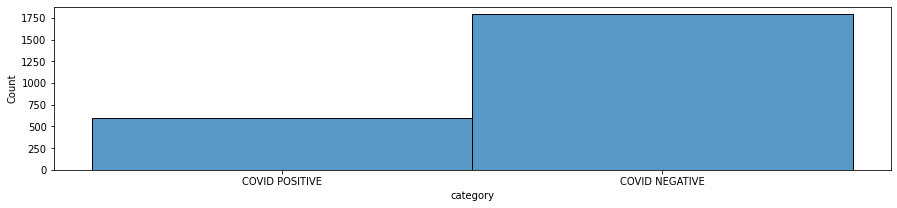

In [16]:
# check class distribution
plt.figure(figsize=(15,3))
sns.histplot(three_df['category'])

three_df['category'].value_counts()

In [17]:
three_df.to_csv('coughvid_df_2class.csv', index=False) 

# Mel-Spectrogram

In [18]:
# resize audio to a uniform length and create mel-spectrogram from audio

cfg = AudioConfig.BasicMelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, f_min=0.0, f_max=4000,
                                      n_mels=64, normalized=False, norm=None, mel=True, to_db=True)

crop8s = ResizeSignal(duration=8000)
a2s = AudioToSpec.from_cfg(cfg)

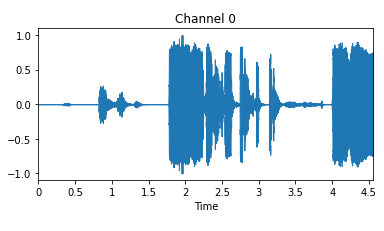

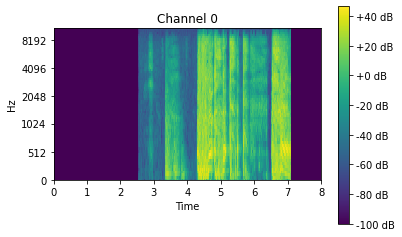

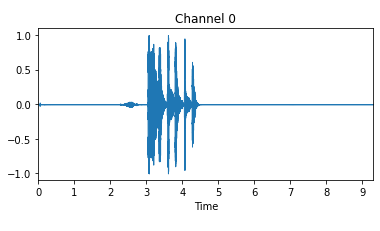

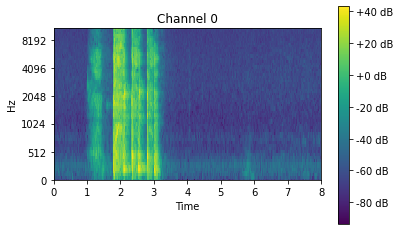

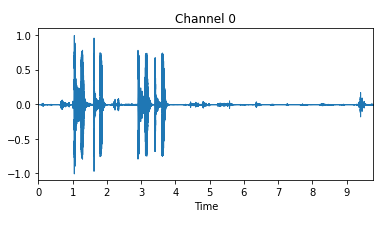

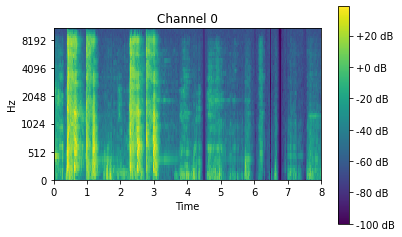

In [19]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop8s, a2s])

for fn in three_df.filename.values[42:45]:
      audio = AudioTensor.create(path+fn)
      audio.show()
      pipe(path+fn).show()

## Dataloader

In [20]:
three_df, three_df_test = train_test_split(three_df, test_size=0.10, random_state=39, stratify=three_df.category.values)

In [21]:
print(three_df.category.value_counts())
print(three_df_test.category.value_counts())

COVID NEGATIVE    1609
COVID POSITIVE     536
Name: category, dtype: int64
COVID NEGATIVE    179
COVID POSITIVE     60
Name: category, dtype: int64


Setting-up type transforms pipelines
1466  9b765189-2dbd-469d-864c-1f797059186a.wav  COVID NEGATIVE
216   5fdfbf5f-b4db-42ad-8971-275b616bcc72.wav  COVID POSITIVE
1490  d2a13309-8f0d-492c-a7de-b5be0c624b1c.wav  COVID NEGATIVE
1548  f9bfbe2f-d9bd-46ae-a859-18ef7b118bc5.wav  COVID NEGATIVE
26    0dbd034b-71d1-4927-8f33-c0645f42c47a.wav  COVID POSITIVE
...                                        ...             ...
2224  f252789f-8c77-44e4-9902-4c7e263e28db.wav  COVID NEGATIVE
890   50f589e4-9b00-4e5d-a7bf-997e952ca154.wav  COVID NEGATIVE
1906  2e387664-2be3-4608-8192-c5b0dd2ec7d8.wav  COVID NEGATIVE
527   e4ec845a-b80b-409b-afa0-81abc3ae3dc7.wav  COVID POSITIVE
427   bdd15ab3-7347-4a29-b5f2-6a63f70bfe6a.wav  COVID POSITIVE

[2145 rows x 2 columns]
Found 2145 items
2 datasets of sizes 1930,215
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/coughvid-wav/public_dataset/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'categor

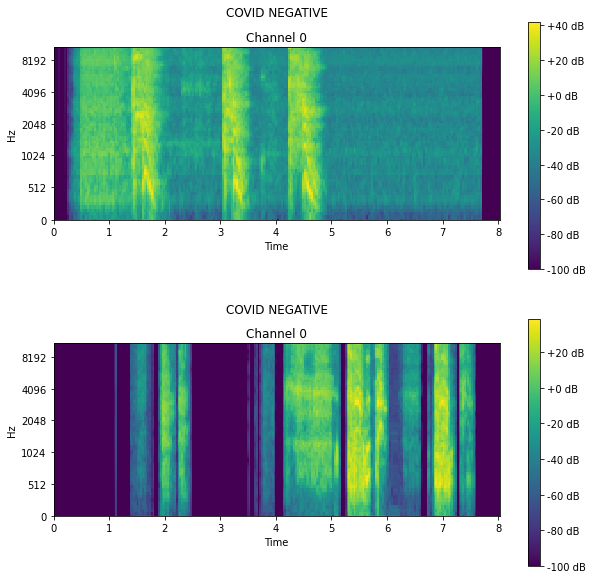

In [22]:
item_tfms = [crop8s, a2s]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path),
                 splitter = TrainTestSplitter(test_size=0.10, random_state=39, 
                                              stratify=three_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(three_df, show_batch=True, figsize=(10, 10))

## Check data distribution

In [23]:
dls = auds.dataloaders(three_df, bs=32)

for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

(array([0, 1]), array([25,  7]))
(array([0, 1]), array([28,  4]))
(array([0, 1]), array([19, 13]))
(array([0, 1]), array([21, 11]))
(array([0, 1]), array([19, 13]))
(array([0, 1]), array([23,  9]))
(array([0, 1]), array([21, 11]))
(array([0, 1]), array([23,  9]))
(array([0, 1]), array([27,  5]))
(array([0, 1]), array([28,  4]))


In [24]:
test_dl = dls.test_dl(three_df_test, with_labels=True)

In [25]:
print(dls.train.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

COVID NEGATIVE    1448
COVID POSITIVE     482
Name: category, dtype: int64
COVID NEGATIVE    161
COVID POSITIVE     54
Name: category, dtype: int64
COVID NEGATIVE    179
COVID POSITIVE     60
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6837209463119507.


Better model found at epoch 0 with accuracy value: 0.6976743936538696.
Better model found at epoch 1 with accuracy value: 0.7441860437393188.
Better model found at epoch 3 with accuracy value: 0.7674418687820435.
Better model found at epoch 8 with accuracy value: 0.7813953757286072.
No improvement since epoch 8: early stopping


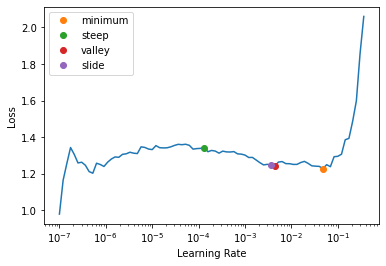

In [28]:
# resnet 18 model
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

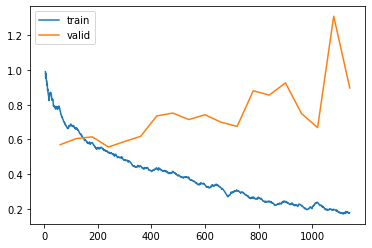

In [29]:
learn.recorder.plot_loss()

0.7531380753138075 0.7308193668528865 0.6061723223013546 0.5969739292364991 0.5969739292364991 0.6532068255369226
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7531380753138075	0.7308193668528865	0.6061723223013546	0.5969739292364991	0.5969739292364991	0.6532068255369226
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       179
           1       0.52      0.28      0.37        60

    accuracy                           0.75       239
   macro avg       0.65      0.60      0.61       239
weighted avg       0.72      0.75      0.73       239



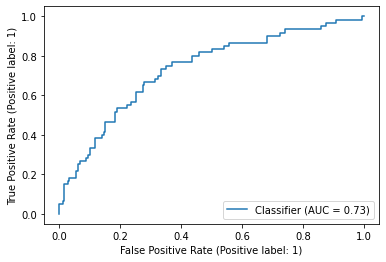

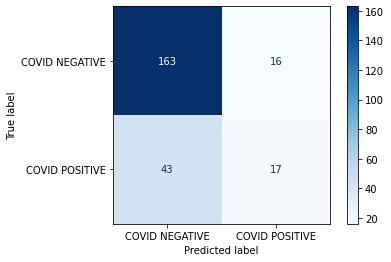

In [31]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^') 
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6418604850769043.


Better model found at epoch 0 with accuracy value: 0.669767439365387.
Better model found at epoch 1 with accuracy value: 0.7023255825042725.
Better model found at epoch 2 with accuracy value: 0.7581395506858826.
Better model found at epoch 6 with accuracy value: 0.7767441868782043.
Better model found at epoch 7 with accuracy value: 0.7813953757286072.
Better model found at epoch 12 with accuracy value: 0.7953488230705261.
Better model found at epoch 19 with accuracy value: 0.8186046481132507.
No improvement since epoch 19: early stopping


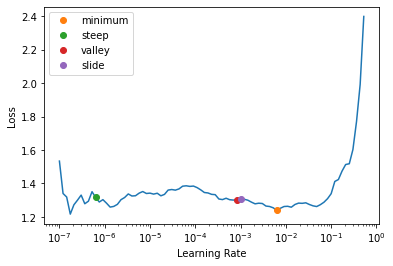

In [26]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

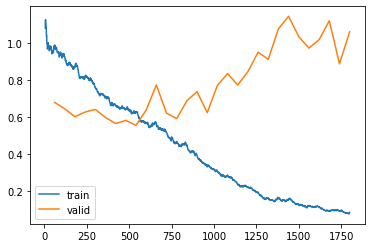

In [27]:
learn.recorder.plot_loss()

0.7112970711297071 0.646927374301676 0.6001697175415202 0.5967411545623836 0.5967411545623836 0.6053966321769122
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7112970711297071	0.646927374301676	0.6001697175415202	0.5967411545623836	0.5967411545623836	0.6053966321769122
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       179
           1       0.42      0.37      0.39        60

    accuracy                           0.71       239
   macro avg       0.61      0.60      0.60       239
weighted avg       0.70      0.71      0.71       239



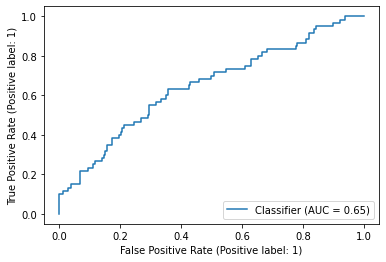

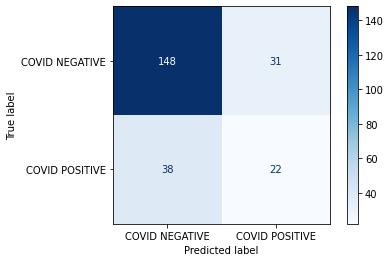

In [28]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6558139324188232.


Better model found at epoch 0 with accuracy value: 0.6279069781303406.
Better model found at epoch 1 with accuracy value: 0.6465116143226624.
Better model found at epoch 2 with accuracy value: 0.7023255825042725.
Better model found at epoch 4 with accuracy value: 0.7116279006004333.
Better model found at epoch 6 with accuracy value: 0.7255814075469971.
Better model found at epoch 7 with accuracy value: 0.734883725643158.
Better model found at epoch 9 with accuracy value: 0.739534854888916.
Better model found at epoch 10 with accuracy value: 0.7581395506858826.
Better model found at epoch 19 with accuracy value: 0.800000011920929.
No improvement since epoch 19: early stopping


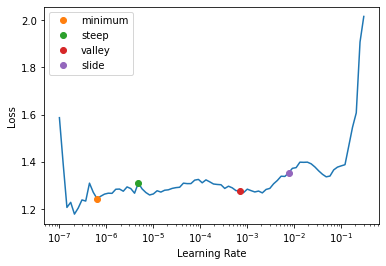

In [29]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

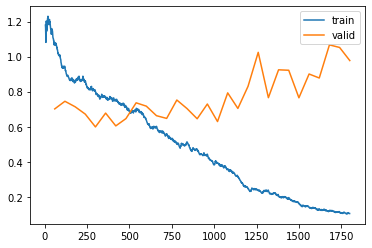

In [30]:
learn.recorder.plot_loss()

0.6861924686192469 0.6069832402234636 0.570607258354294 0.568901303538175 0.568901303538175 0.5731225296442688
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6861924686192469	0.6069832402234636	0.570607258354294	0.568901303538175	0.568901303538175	0.5731225296442688
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       179
           1       0.36      0.33      0.35        60

    accuracy                           0.69       239
   macro avg       0.57      0.57      0.57       239
weighted avg       0.68      0.69      0.68       239



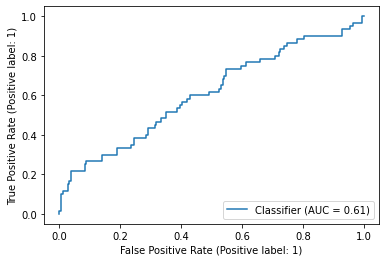

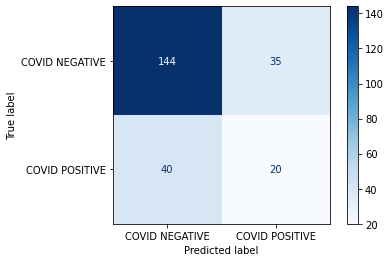

In [31]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^') 
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6604651212692261.


Better model found at epoch 0 with accuracy value: 0.7441860437393188.
Better model found at epoch 1 with accuracy value: 0.7534883618354797.
Better model found at epoch 4 with accuracy value: 0.7581395506858826.
Better model found at epoch 5 with accuracy value: 0.7767441868782043.
Better model found at epoch 9 with accuracy value: 0.8186046481132507.
Better model found at epoch 15 with accuracy value: 0.8232558369636536.
No improvement since epoch 15: early stopping


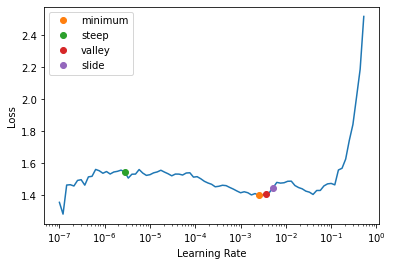

In [32]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

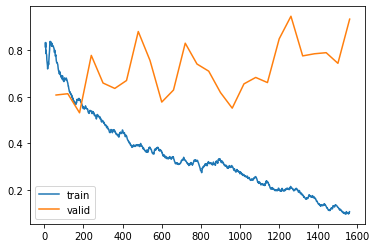

In [33]:
learn.recorder.plot_loss()

0.7447698744769874 0.6237430167597765 0.5928222315319089 0.5858472998137803 0.5858472998137803 0.6356281259193881
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7447698744769874	0.6237430167597765	0.5928222315319089	0.5858472998137803	0.5858472998137803	0.6356281259193881
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       179
           1       0.48      0.27      0.34        60

    accuracy                           0.74       239
   macro avg       0.64      0.59      0.59       239
weighted avg       0.71      0.74      0.72       239



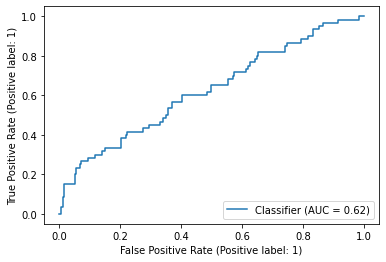

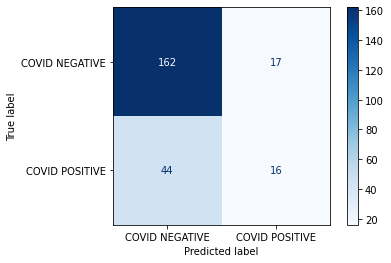

In [34]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^') 
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6790697574615479.


Better model found at epoch 0 with accuracy value: 0.7302325367927551.
Better model found at epoch 1 with accuracy value: 0.7581395506858826.
Better model found at epoch 2 with accuracy value: 0.7674418687820435.
Better model found at epoch 5 with accuracy value: 0.7906976938247681.
No improvement since epoch 5: early stopping


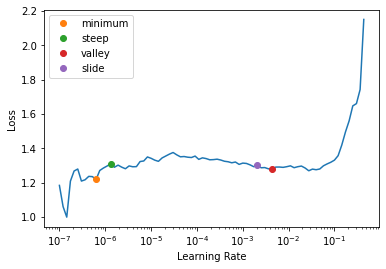

In [35]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

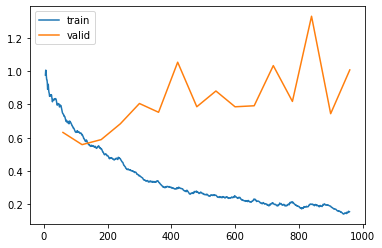

In [36]:
learn.recorder.plot_loss()

0.7615062761506276 0.6422718808193668 0.5921867983834755 0.5859404096834264 0.5859404096834264 0.6725233644859814
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7615062761506276	0.6422718808193668	0.5921867983834755	0.5859404096834264	0.5859404096834264	0.6725233644859814
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       179
           1       0.56      0.23      0.33        60

    accuracy                           0.76       239
   macro avg       0.67      0.59      0.59       239
weighted avg       0.73      0.76      0.72       239



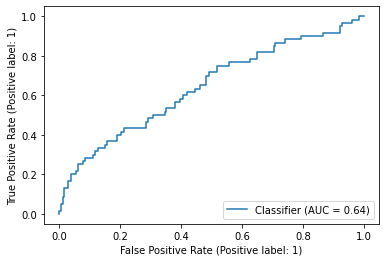

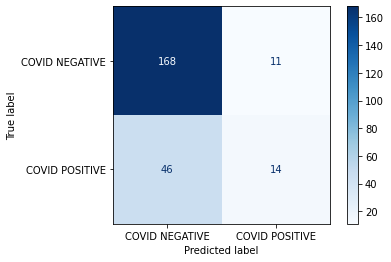

In [37]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^') 
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.604651153087616.


Better model found at epoch 0 with accuracy value: 0.6930232644081116.
Better model found at epoch 1 with accuracy value: 0.7023255825042725.
Better model found at epoch 2 with accuracy value: 0.739534854888916.
Better model found at epoch 4 with accuracy value: 0.7581395506858826.
Better model found at epoch 6 with accuracy value: 0.7627906799316406.
Better model found at epoch 16 with accuracy value: 0.7720929980278015.
No improvement since epoch 16: early stopping


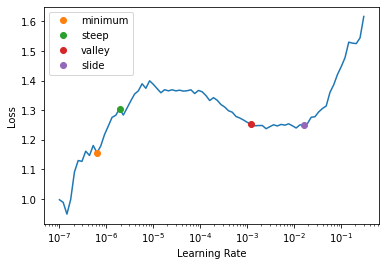

In [38]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

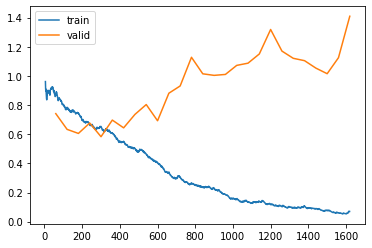

In [39]:
learn.recorder.plot_loss()

0.7489539748953975 0.6467411545623837 0.6206349206349207 0.6108007448789572 0.6108007448789572 0.6494974874371859
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7489539748953975	0.6467411545623837	0.6206349206349207	0.6108007448789572	0.6108007448789572	0.6494974874371859
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       179
           1       0.50      0.33      0.40        60

    accuracy                           0.75       239
   macro avg       0.65      0.61      0.62       239
weighted avg       0.72      0.75      0.73       239



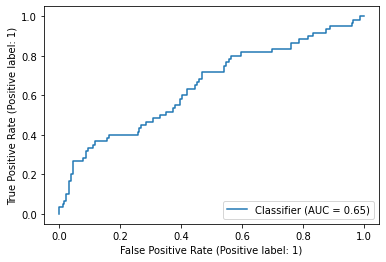

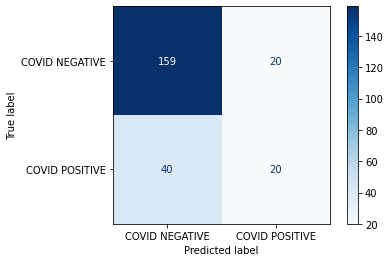

In [40]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^') 
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.7162790894508362.


Better model found at epoch 0 with accuracy value: 0.739534854888916.
Better model found at epoch 1 with accuracy value: 0.7860465049743652.
No improvement since epoch 1: early stopping


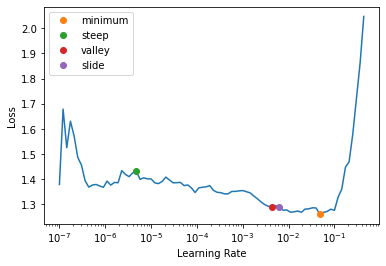

In [41]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

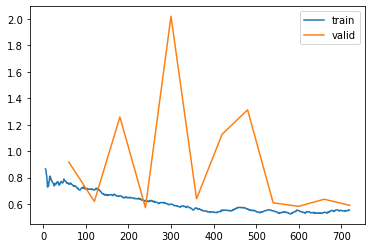

In [42]:
learn.recorder.plot_loss()

0.7280334728033473 0.6843575418994414 0.5433165770056149 0.546973929236499 0.546973929236499 0.5881376659678547
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7280334728033473	0.6843575418994414	0.5433165770056149	0.546973929236499	0.546973929236499	0.5881376659678547
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       179
           1       0.41      0.18      0.25        60

    accuracy                           0.73       239
   macro avg       0.59      0.55      0.54       239
weighted avg       0.68      0.73      0.69       239



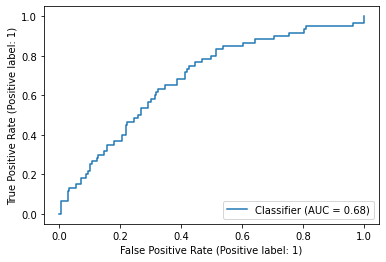

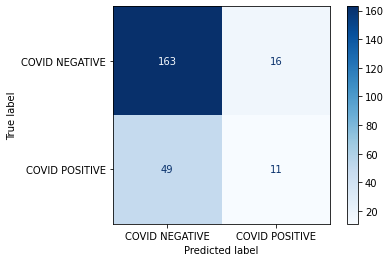

In [43]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.7116279006004333.


Better model found at epoch 0 with accuracy value: 0.7255814075469971.
Better model found at epoch 1 with accuracy value: 0.7441860437393188.
Better model found at epoch 2 with accuracy value: 0.7488372325897217.
Better model found at epoch 3 with accuracy value: 0.7720929980278015.
No improvement since epoch 3: early stopping


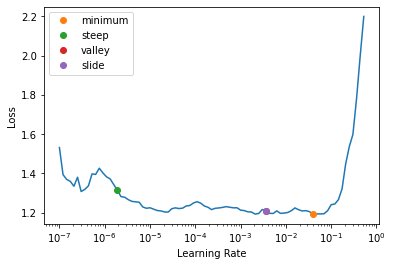

In [44]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

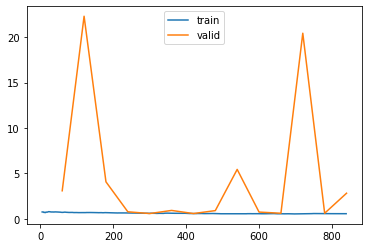

In [45]:
learn.recorder.plot_loss()

0.7573221757322176 0.6802607076350093 0.5888111058376839 0.5831471135940409 0.5831471135940409 0.6612495485734922
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7573221757322176	0.6802607076350093	0.5888111058376839	0.5831471135940409	0.5831471135940409	0.6612495485734922
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       179
           1       0.54      0.23      0.33        60

    accuracy                           0.76       239
   macro avg       0.66      0.58      0.59       239
weighted avg       0.72      0.76      0.72       239



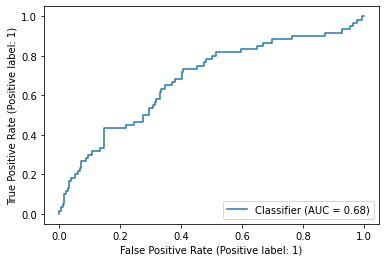

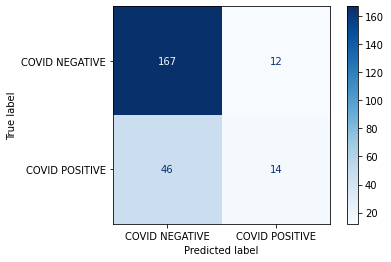

In [46]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6604651212692261.


Better model found at epoch 0 with accuracy value: 0.7209302186965942.
Better model found at epoch 1 with accuracy value: 0.7302325367927551.
Better model found at epoch 2 with accuracy value: 0.7767441868782043.
No improvement since epoch 2: early stopping


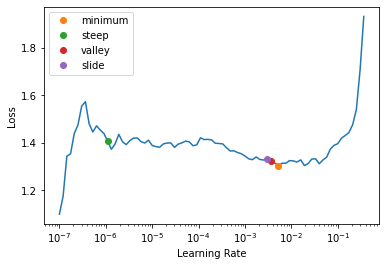

In [47]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

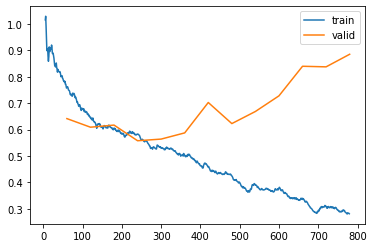

In [48]:
learn.recorder.plot_loss()

0.7238493723849372 0.6809124767225326 0.6103260869565218 0.60512104283054 0.60512104283054 0.6194708994708995
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7238493723849372	0.6809124767225326	0.6103260869565218	0.60512104283054	0.60512104283054	0.6194708994708995
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       179
           1       0.44      0.37      0.40        60

    accuracy                           0.72       239
   macro avg       0.62      0.61      0.61       239
weighted avg       0.71      0.72      0.72       239



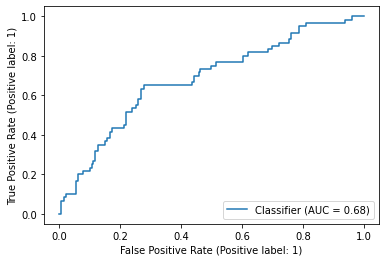

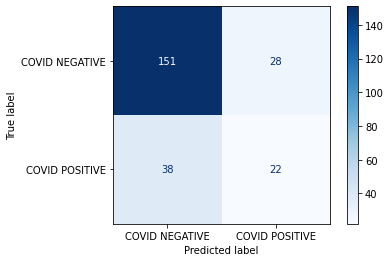

In [49]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.7116279006004333.


Better model found at epoch 0 with accuracy value: 0.7488372325897217.
Better model found at epoch 1 with accuracy value: 0.7534883618354797.
Better model found at epoch 3 with accuracy value: 0.7953488230705261.
Better model found at epoch 4 with accuracy value: 0.800000011920929.
Better model found at epoch 9 with accuracy value: 0.804651141166687.
Better model found at epoch 12 with accuracy value: 0.8093023300170898.
No improvement since epoch 12: early stopping


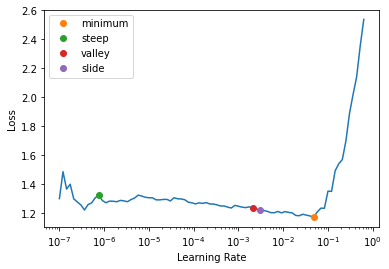

In [50]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

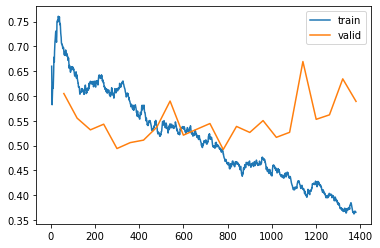

In [51]:
learn.recorder.plot_loss()

0.7364016736401674 0.6816573556797021 0.6045644352233632 0.5968808193668529 0.5968808193668529 0.6281719635378172
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7364016736401674	0.6816573556797021	0.6045644352233632	0.5968808193668529	0.5968808193668529	0.6281719635378172
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       179
           1       0.46      0.32      0.38        60

    accuracy                           0.74       239
   macro avg       0.63      0.60      0.60       239
weighted avg       0.71      0.74      0.72       239



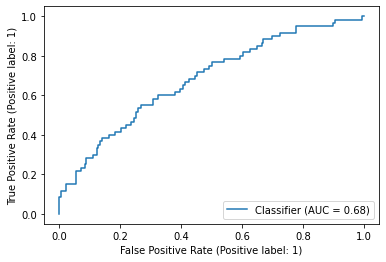

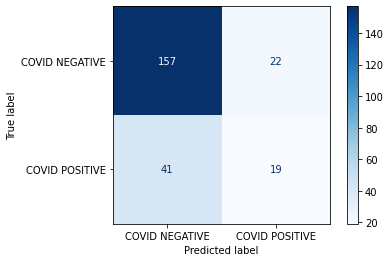

In [52]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

# Models: 1cycle policy

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5627906918525696.
Better model found at epoch 1 with accuracy value: 0.5813953280448914.
Better model found at epoch 2 with accuracy value: 0.6790697574615479.
Better model found at epoch 3 with accuracy value: 0.739534854888916.
Better model found at epoch 5 with accuracy value: 0.7581395506858826.
Better model found at epoch 7 with accuracy value: 0.7674418687820435.
Better model found at epoch 9 with accuracy value: 0.7720929980278015.
Better model found at epoch 15 with accuracy value: 0.7860465049743652.
No improvement since epoch 15: early stopping


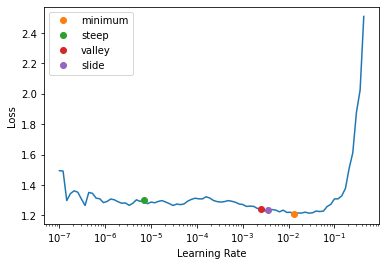

In [53]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

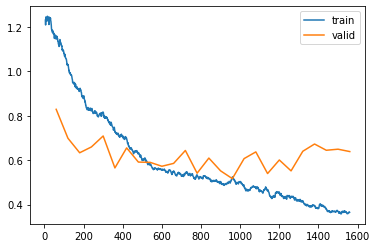

In [54]:
learn.recorder.plot_loss()

0.7322175732217573 0.7172253258845438 0.6120917021708258 0.6051675977653631 0.6051675977653631 0.6272246001351656
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7322175732217573	0.7172253258845438	0.6120917021708258	0.6051675977653631	0.6051675977653631	0.6272246001351656
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       179
           1       0.46      0.35      0.40        60

    accuracy                           0.73       239
   macro avg       0.63      0.61      0.61       239
weighted avg       0.71      0.73      0.72       239



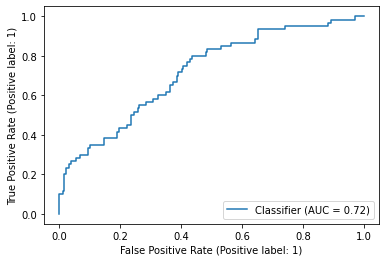

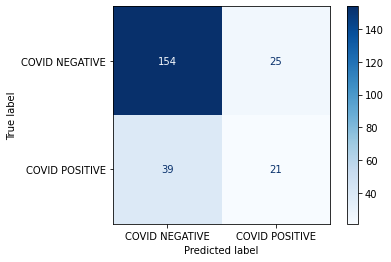

In [55]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.5441860556602478.
Better model found at epoch 1 with accuracy value: 0.6465116143226624.
Better model found at epoch 2 with accuracy value: 0.739534854888916.
Better model found at epoch 3 with accuracy value: 0.7581395506858826.
Better model found at epoch 8 with accuracy value: 0.7627906799316406.
Better model found at epoch 15 with accuracy value: 0.7674418687820435.
Better model found at epoch 18 with accuracy value: 0.7953488230705261.
No improvement since epoch 18: early stopping


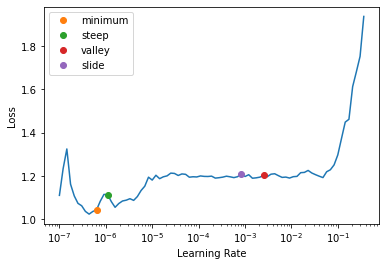

In [56]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

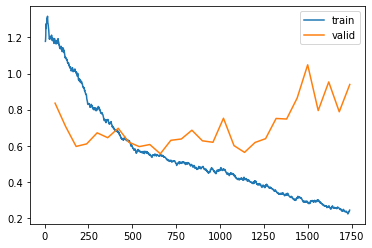

In [57]:
learn.recorder.plot_loss()

0.7489539748953975 0.6322160148975792 0.6149301825993556 0.6052607076350093 0.6052607076350093 0.6480099502487562
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7489539748953975	0.6322160148975792	0.6149301825993556	0.6052607076350093	0.6052607076350093	0.6480099502487562
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       179
           1       0.50      0.32      0.39        60

    accuracy                           0.75       239
   macro avg       0.65      0.61      0.61       239
weighted avg       0.72      0.75      0.73       239



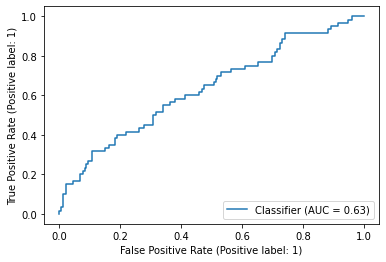

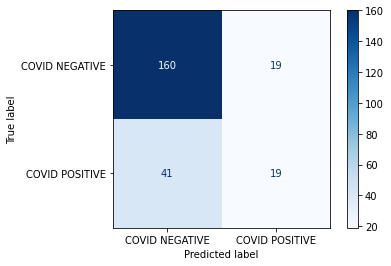

In [58]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.5488371849060059.
Better model found at epoch 2 with accuracy value: 0.5534883737564087.
Better model found at epoch 4 with accuracy value: 0.5627906918525696.
Better model found at epoch 5 with accuracy value: 0.6279069781303406.
Better model found at epoch 6 with accuracy value: 0.6511628031730652.
Better model found at epoch 8 with accuracy value: 0.6976743936538696.
Better model found at epoch 11 with accuracy value: 0.7069767713546753.
Better model found at epoch 13 with accuracy value: 0.7116279006004333.
Better model found at epoch 14 with accuracy value: 0.7255814075469971.
Better model found at epoch 16 with accuracy value: 0.7441860437393188.
Better model found at epoch 20 with accuracy value: 0.7860465049743652.
No improvement since epoch 20: early stopping


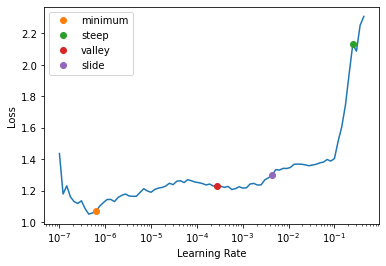

In [59]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

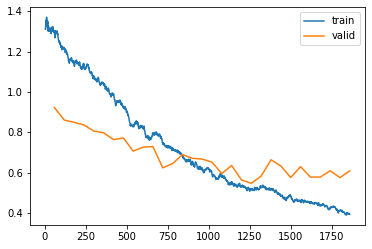

In [60]:
learn.recorder.plot_loss()

0.7573221757322176 0.6810055865921787 0.6385586149353358 0.6274674115456238 0.6274674115456238 0.6654580613971477
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7573221757322176	0.6810055865921787	0.6385586149353358	0.6274674115456238	0.6274674115456238	0.6654580613971477
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       179
           1       0.52      0.37      0.43        60

    accuracy                           0.76       239
   macro avg       0.67      0.63      0.64       239
weighted avg       0.74      0.76      0.74       239



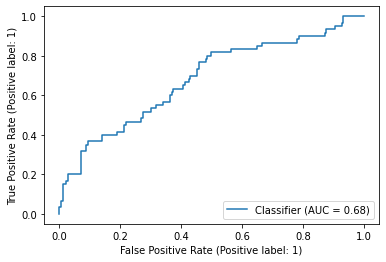

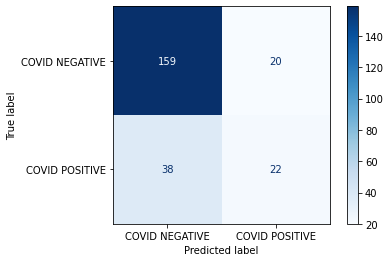

In [61]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.4790697693824768.
Better model found at epoch 1 with accuracy value: 0.5674418807029724.
Better model found at epoch 3 with accuracy value: 0.5860465168952942.
Better model found at epoch 4 with accuracy value: 0.6000000238418579.
Better model found at epoch 7 with accuracy value: 0.6604651212692261.
Better model found at epoch 9 with accuracy value: 0.7069767713546753.
Better model found at epoch 12 with accuracy value: 0.734883725643158.
Better model found at epoch 15 with accuracy value: 0.7534883618354797.
Better model found at epoch 18 with accuracy value: 0.7581395506858826.
Better model found at epoch 26 with accuracy value: 0.7674418687820435.
Better model found at epoch 30 with accuracy value: 0.7720929980278015.
Better model found at epoch 32 with accuracy value: 0.7767441868782043.
Better model found at epoch 34 with accuracy value: 0.800000011920929.
No improvement since epoch 34: early stopping


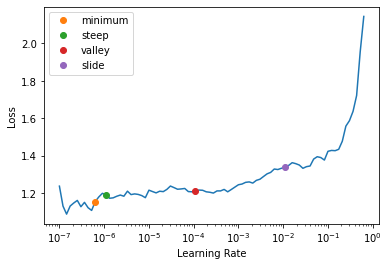

In [62]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

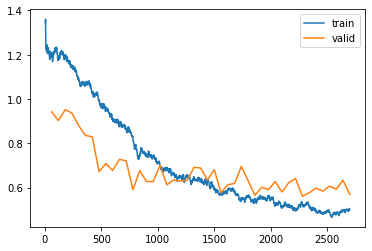

In [63]:
learn.recorder.plot_loss()

0.7447698744769874 0.6796089385474859 0.6327430284404363 0.6246275605214153 0.6246275605214153 0.6483266843971631
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7447698744769874	0.6796089385474859	0.6327430284404363	0.6246275605214153	0.6246275605214153	0.6483266843971631
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       179
           1       0.49      0.38      0.43        60

    accuracy                           0.74       239
   macro avg       0.65      0.62      0.63       239
weighted avg       0.73      0.74      0.73       239



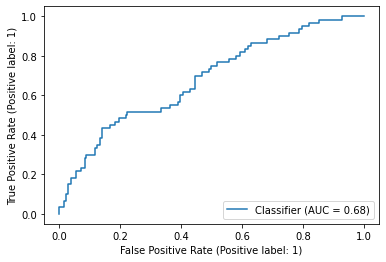

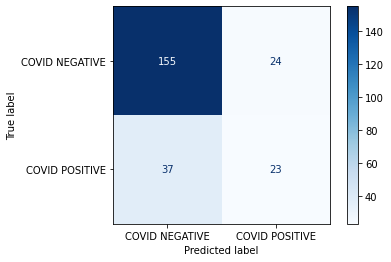

In [64]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.5534883737564087.
Better model found at epoch 1 with accuracy value: 0.6232557892799377.
Better model found at epoch 2 with accuracy value: 0.6651162505149841.
Better model found at epoch 3 with accuracy value: 0.734883725643158.
Better model found at epoch 7 with accuracy value: 0.739534854888916.
Better model found at epoch 8 with accuracy value: 0.7581395506858826.
Better model found at epoch 15 with accuracy value: 0.7674418687820435.
Better model found at epoch 20 with accuracy value: 0.7767441868782043.
No improvement since epoch 20: early stopping


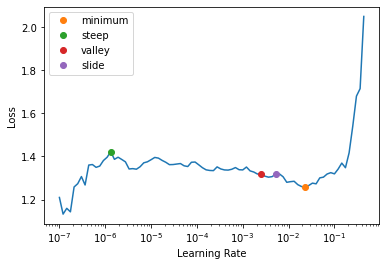

In [65]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

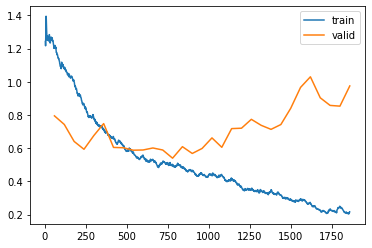

In [66]:
learn.recorder.plot_loss()

0.7280334728033473 0.6395716945996276 0.5588778146917681 0.5580540037243948 0.5580540037243948 0.5966966501240695
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7280334728033473	0.6395716945996276	0.5588778146917681	0.5580540037243948	0.5580540037243948	0.5966966501240695
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       179
           1       0.42      0.22      0.29        60

    accuracy                           0.73       239
   macro avg       0.60      0.56      0.56       239
weighted avg       0.68      0.73      0.69       239



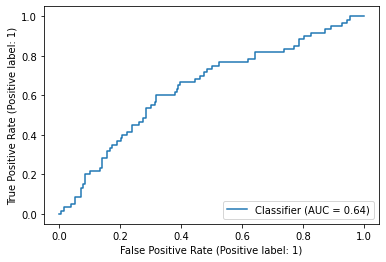

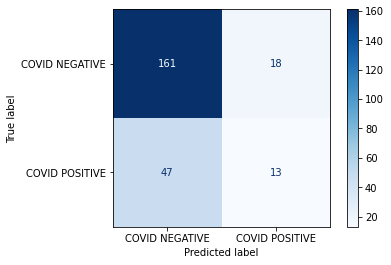

In [67]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.5860465168952942.
Better model found at epoch 1 with accuracy value: 0.6651162505149841.
Better model found at epoch 2 with accuracy value: 0.7534883618354797.
Better model found at epoch 5 with accuracy value: 0.7627906799316406.
No improvement since epoch 5: early stopping


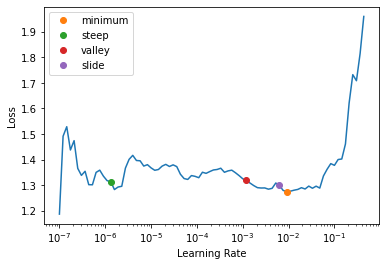

In [68]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

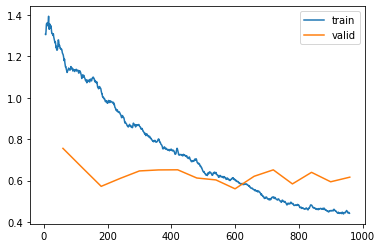

In [69]:
learn.recorder.plot_loss()

0.7112970711297071 0.5817504655493482 0.5789352738414402 0.5745810055865922 0.5745810055865922 0.5917525773195876
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7112970711297071	0.5817504655493482	0.5789352738414402	0.5745810055865922	0.5745810055865922	0.5917525773195876
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       179
           1       0.40      0.30      0.34        60

    accuracy                           0.71       239
   macro avg       0.59      0.57      0.58       239
weighted avg       0.69      0.71      0.70       239



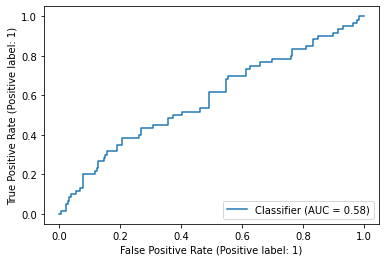

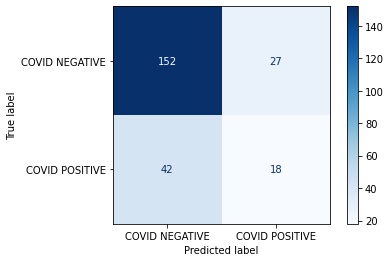

In [70]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.5860465168952942.
Better model found at epoch 1 with accuracy value: 0.6604651212692261.
Better model found at epoch 2 with accuracy value: 0.669767439365387.
Better model found at epoch 3 with accuracy value: 0.7162790894508362.
Better model found at epoch 4 with accuracy value: 0.7767441868782043.
Better model found at epoch 5 with accuracy value: 0.7860465049743652.
Better model found at epoch 6 with accuracy value: 0.7906976938247681.
Better model found at epoch 15 with accuracy value: 0.800000011920929.
No improvement since epoch 15: early stopping


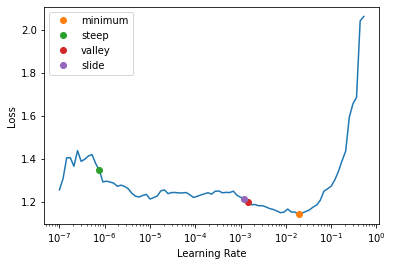

In [71]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

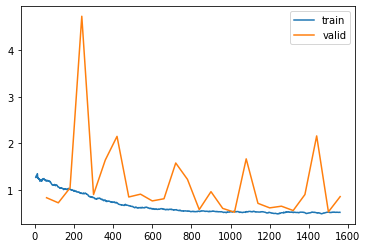

In [72]:
learn.recorder.plot_loss()

0.7322175732217573 0.6120111731843575 0.5289480167528948 0.5386871508379888 0.5386871508379888 0.5870339338081274
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7322175732217573	0.6120111731843575	0.5289480167528948	0.5386871508379888	0.5386871508379888	0.5870339338081274
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       179
           1       0.41      0.15      0.22        60

    accuracy                           0.73       239
   macro avg       0.59      0.54      0.53       239
weighted avg       0.68      0.73      0.68       239



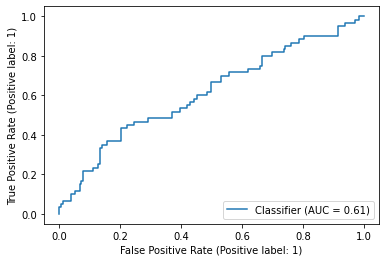

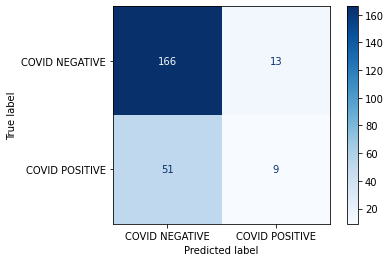

In [73]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.6558139324188232.
Better model found at epoch 1 with accuracy value: 0.7488372325897217.
Better model found at epoch 9 with accuracy value: 0.7627906799316406.
Better model found at epoch 14 with accuracy value: 0.7813953757286072.
No improvement since epoch 14: early stopping


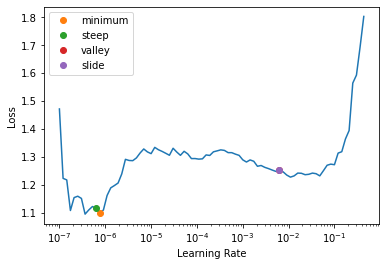

In [74]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

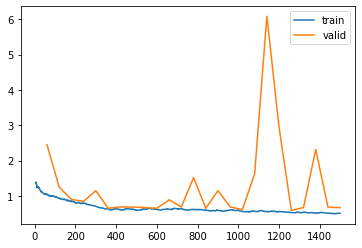

In [75]:
learn.recorder.plot_loss()

0.7489539748953975 0.6455307262569832 0.5893470790378007 0.583100558659218 0.583100558659218 0.6423444976076556
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7489539748953975	0.6455307262569832	0.5893470790378007	0.583100558659218	0.583100558659218	0.6423444976076556
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       179
           1       0.50      0.25      0.33        60

    accuracy                           0.75       239
   macro avg       0.64      0.58      0.59       239
weighted avg       0.71      0.75      0.72       239



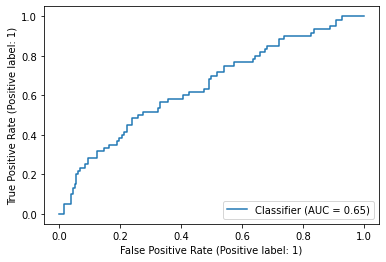

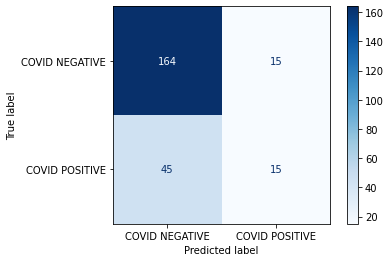

In [76]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.5116279125213623.
Better model found at epoch 2 with accuracy value: 0.6139534711837769.
Better model found at epoch 3 with accuracy value: 0.6511628031730652.
Better model found at epoch 4 with accuracy value: 0.6604651212692261.
Better model found at epoch 5 with accuracy value: 0.6930232644081116.
Better model found at epoch 7 with accuracy value: 0.7209302186965942.
Better model found at epoch 8 with accuracy value: 0.7302325367927551.
Better model found at epoch 9 with accuracy value: 0.7488372325897217.
Better model found at epoch 11 with accuracy value: 0.7767441868782043.
Better model found at epoch 16 with accuracy value: 0.800000011920929.
No improvement since epoch 16: early stopping


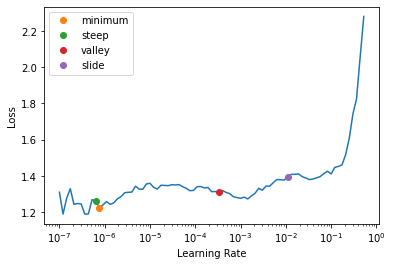

In [77]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

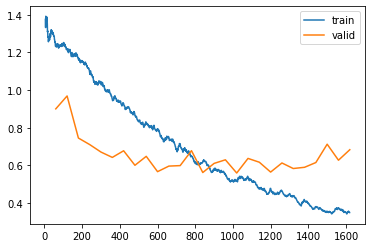

In [78]:
learn.recorder.plot_loss()

0.7071129707112971 0.6217877094972067 0.5757252992493406 0.5717877094972067 0.5717877094972067 0.5868438837576031
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7071129707112971	0.6217877094972067	0.5757252992493406	0.5717877094972067	0.5717877094972067	0.5868438837576031
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       179
           1       0.39      0.30      0.34        60

    accuracy                           0.71       239
   macro avg       0.59      0.57      0.58       239
weighted avg       0.68      0.71      0.69       239



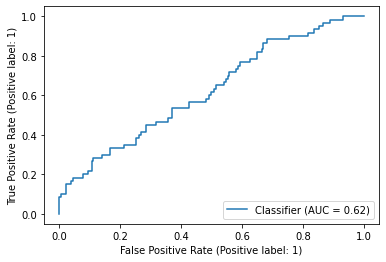

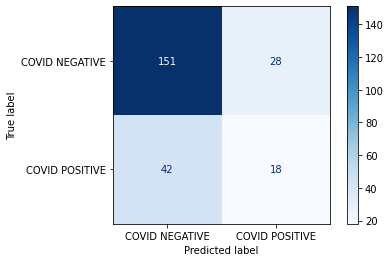

In [79]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.4697674512863159.
Better model found at epoch 1 with accuracy value: 0.7069767713546753.
Better model found at epoch 4 with accuracy value: 0.7767441868782043.
Better model found at epoch 11 with accuracy value: 0.7860465049743652.
Better model found at epoch 15 with accuracy value: 0.8186046481132507.
No improvement since epoch 15: early stopping


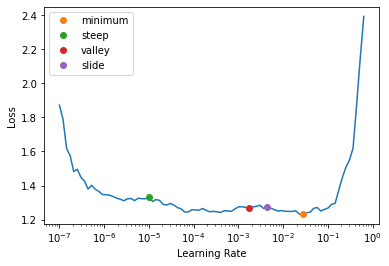

In [80]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

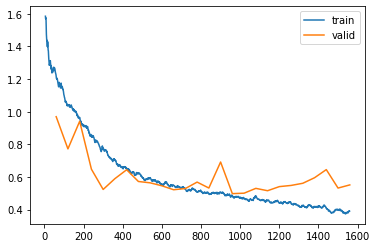

In [81]:
learn.recorder.plot_loss()

0.7656903765690377 0.6735567970204842 0.6350349040139617 0.6219739292364991 0.6219739292364991 0.6792556102900931
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7656903765690377	0.6735567970204842	0.6350349040139617	0.6219739292364991	0.6219739292364991	0.6792556102900931
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       179
           1       0.56      0.33      0.42        60

    accuracy                           0.77       239
   macro avg       0.68      0.62      0.64       239
weighted avg       0.74      0.77      0.74       239



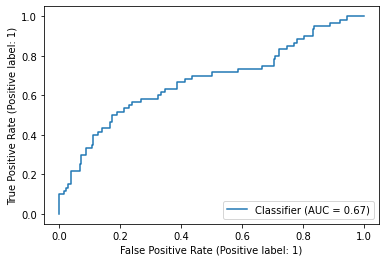

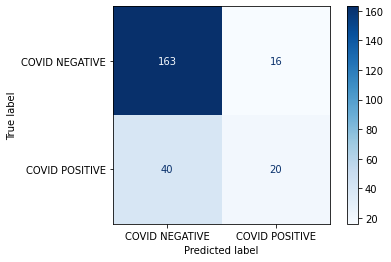

In [82]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()